# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

Se toman los daily (en nuestro caso weekly) coeficientes de información, como el mejor indicador y no los totales.

## Imports & Settings

In [160]:
import warnings
warnings.filterwarnings('ignore')

In [161]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from scipy.stats import spearmanr, pearsonr
from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

sns.set_style('whitegrid')




DATA_STORE = 'data_normalized/assets.h5'
DATA_ITEM = 'engineered_features_trimmed'
results_path = Path('results_normalized_trimmed', 'us_stocks')

idx = pd.IndexSlice

In [162]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
rf_train_params = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf','max_depth']
catboost_train_params = ['max_depth', 'min_child_samples']

In [163]:

if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [164]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [165]:
# lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
# lgb_metrics.info()

In [166]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          464           1              594
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [167]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()


id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

# lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
# lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')

# lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
# lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


In [168]:
lgb_metrics.sort_values('ic', ascending=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
166,1,464,1,0.30,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,150,0.064920
220,1,464,1,0.30,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,200,0.061667
113,1,464,1,0.30,4.0,0.95,250.0,0.025484,200.0,0.031818,200.0,100,0.060737
436,1,464,1,0.30,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,400,0.060492
274,1,464,1,0.30,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,250,0.059617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1,464,1,0.01,32.0,0.30,250.0,0.010369,50.0,0.013636,250.0,150,-0.013839
214,1,464,1,0.01,128.0,0.30,250.0,0.010369,50.0,0.013636,250.0,150,-0.013839
123,1,464,1,0.30,128.0,0.30,500.0,0.016607,75.0,0.022727,75.0,100,-0.015391
261,1,464,1,0.01,32.0,0.30,250.0,0.010369,50.0,0.013636,250.0,200,-0.015420


In [169]:
lgb_daily_ic.sort_values('ic', ascending=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
419,1,464,1,0.30,4,0.30,250,75,0.042573
288,1,464,1,0.10,4,0.95,1000,100,0.033666
353,1,464,1,0.10,32,0.95,1000,75,0.033525
320,1,464,1,0.10,8,0.95,1000,75,0.033525
32,1,464,1,0.01,4,0.60,1000,500,0.033166
...,...,...,...,...,...,...,...,...,...
336,1,464,1,0.10,32,0.30,500,300,-0.021775
339,1,464,1,0.10,32,0.30,500,450,-0.021970
372,1,464,1,0.10,128,0.30,500,450,-0.021970
199,1,464,1,0.01,128,0.95,250,75,-0.023100


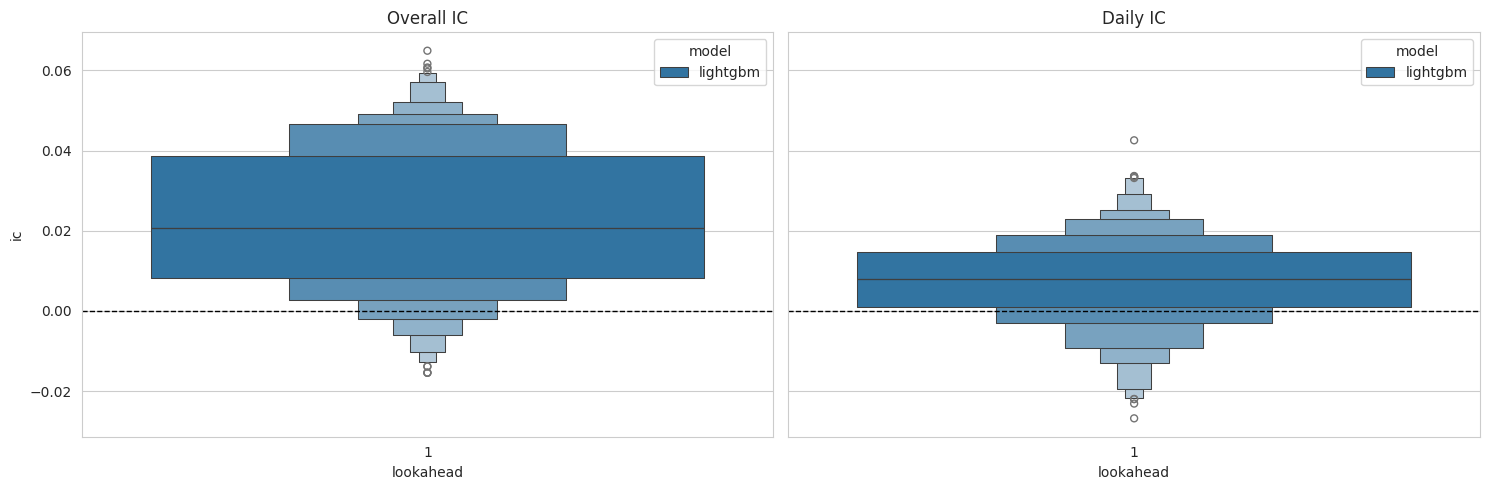

In [170]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_metrics.assign(model='lightgbm'), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_daily_ic.assign(model='lightgbm'), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [171]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic')).sort_values(["feature_fraction", "ic"], ascending=[True, False])

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
419,1,464,1,0.30,4,0.30,250,75,0.042573
418,1,464,1,0.30,4,0.30,250,50,0.033147
420,1,464,1,0.30,4,0.30,250,100,0.032860
32,1,464,1,0.01,4,0.60,1000,500,0.033166
398,1,464,1,0.10,128,0.60,500,100,0.030109
242,1,464,1,0.10,4,0.60,250,50,0.029217
288,1,464,1,0.10,4,0.95,1000,100,0.033666
320,1,464,1,0.10,8,0.95,1000,75,0.033525
353,1,464,1,0.10,32,0.95,1000,75,0.033525
213,1,464,1,0.01,128,0.95,500,200,0.030859


In [172]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic')).sort_values(["feature_fraction", "ic"], ascending=[True, False])
# lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
166,1,464,1,0.3,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,150,0.064920
220,1,464,1,0.3,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,200,0.061667
113,1,464,1,0.3,4.0,0.95,250.0,0.025484,200.0,0.031818,200.0,100,0.060737
436,1,464,1,0.3,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,400,0.060492
274,1,464,1,0.3,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,250,0.059617
490,1,464,1,0.3,4.0,0.95,1000.0,0.018707,50.0,0.027273,100.0,450,0.059144
216,1,464,1,0.3,8.0,0.95,1000.0,0.016483,50.0,0.034127,50.0,200,0.058903
228,1,464,1,0.3,128.0,0.95,1000.0,0.016483,50.0,0.034127,50.0,200,0.058903
270,1,464,1,0.3,8.0,0.95,1000.0,0.016483,50.0,0.034127,50.0,250,0.057291
282,1,464,1,0.3,128.0,0.95,1000.0,0.016483,50.0,0.034127,50.0,250,0.057291


In [173]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
9,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,50,0.011494
63,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,75,0.003436
117,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,100,0.003062
171,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,150,0.002945
225,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,200,0.006286
279,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,250,0.006391
333,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,300,0.012552
387,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,350,0.016063
441,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,400,0.016749
495,1,464,1,0.3,4.0,0.3,250.0,0.042573,75.0,0.036615,75.0,450,0.017856


### Visualization

#### LightGBM

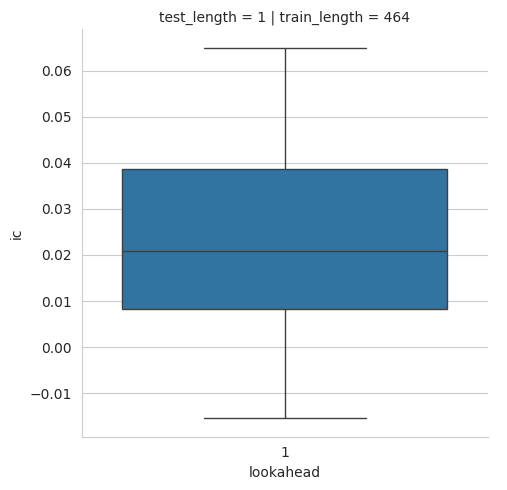

In [174]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

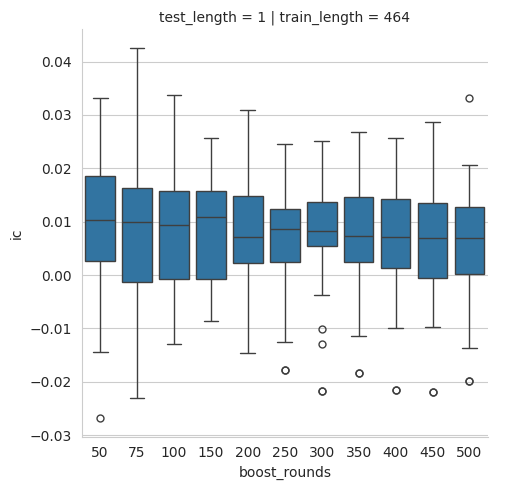

In [175]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [176]:
# lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         594 non-null    int64  
 1   train_length      594 non-null    int64  
 2   test_length       594 non-null    int64  
 3   learning_rate     594 non-null    float64
 4   num_leaves        594 non-null    int64  
 5   feature_fraction  594 non-null    float64
 6   min_data_in_leaf  594 non-null    int64  
 7   boost_rounds      594 non-null    int64  
 8   ic                594 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 41.9 KB


In [177]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [178]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [179]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        464.0
test_length           1.0
learning_rate         0.3
num_leaves            4.0
feature_fraction      0.3
min_data_in_leaf    250.0
boost_rounds         75.0
Name: 419, dtype: float64

In [180]:
# best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [181]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

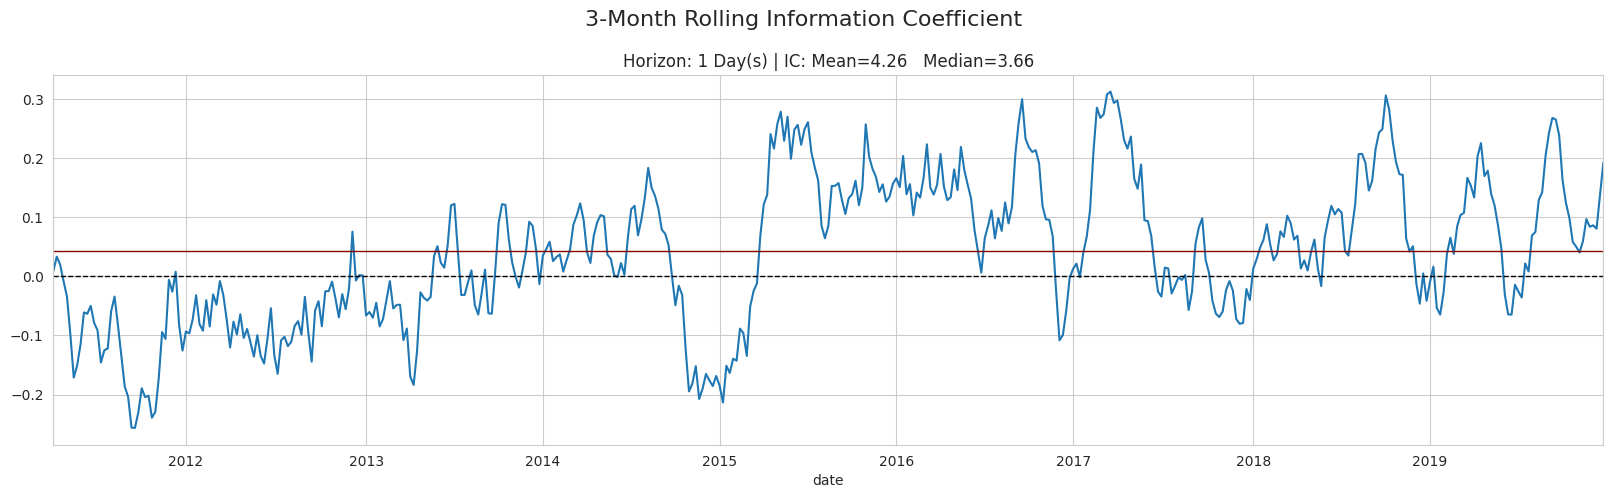

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
# axes = axes.flatten()


for i, t in enumerate([1]): #modificado para meses un lookahead
    params = get_lgb_params(lgb_daily_ic, t=1, best=0)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    #rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3*4).ic.mean().dropna()#semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes, title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes.axhline(avg, c='darkred', lw=1)
    axes.axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
# fig.tight_layout()
fig.subplots_adjust(top=0.85);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [183]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()
# best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')

In [184]:

best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5148 entries, ('IYR', Timestamp('2011-01-16 00:00:00')) to ('XLY', Timestamp('2019-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5148 non-null   float64
 1   1       5148 non-null   float64
 2   2       5148 non-null   float64
 3   3       5148 non-null   float64
 4   4       5148 non-null   float64
 5   5       5148 non-null   float64
 6   6       5148 non-null   float64
 7   7       5148 non-null   float64
 8   8       5148 non-null   float64
 9   9       5148 non-null   float64
dtypes: float64(10)
memory usage: 460.2+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [185]:
#modificado
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    
    with pd.HDFStore(DATA_STORE) as store:
        prices = (store['data_close'])  
    display(prices)
    return (prices.loc[idx[tickers, '2012': '2024'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC')
            .resample('W').last())

In [186]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [187]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

open        high         low       close     volume  \
ticker date                                                                    
IYR    2000-01-03   19.267872   19.267872   18.455524   18.582453  1185699.0   
       2000-01-04   18.176279   18.201666   17.605097   17.770105   885705.0   
       2000-01-05   17.770105   17.960501   17.440088   17.630484   717181.0   
       2000-01-06   17.681255   18.518990   17.681255   18.404753   415832.0   
       2000-01-07   18.531681   18.734768   18.277822   18.709383   468149.0   
...                       ...         ...         ...         ...        ...   
XLY    2024-12-20  226.039993  232.509995  225.500000  228.910004  5457900.0   
       2024-12-23  228.889999  229.399994  226.179993  229.169998  2961200.0   
       2024-12-24  230.139999  234.500000  229.949997  234.470001  1276300.0   
       2024-12-26  233.970001  234.449997  232.570007  233.600006  2054800.0   
       2024-12-27  232.050003  232.050003  228.630005  229.740005  3048600.0   

                    Adj Close  
ticker date                    
IYR    2000-01-03   11.303078  
       2000-01-04   10.808952  
       2000-01-05   10.724023  
       2000-01-06   11.194987  
       2000-01-07   11.380281  
...                       ...  
XLY    2024-12-20  228.477005  
       2024-12-23  229.169998  
       2024-12-24  234.470001  
       2024-12-26  233.600006  
       2024-12-27  229.740005  

[69157 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678 entries, 2012-01-08 00:00:00+00:00 to 2024-12-29 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     678 non-null    float64
 1   VOX     678 non-null    float64
 2   XLB     678 non-null    float64
 3   XLE     678 non-null    float64
 4   XLF     678 non-null    float64
 5   XLI     678 non-null    float64
 6   XLK     678 non-null    float64
 7   XLP     678 non-null    float64
 8   XLU     678 non-null    float64
 9   XLV     678 non-null    float64
 10  XLY     678 non-null    float64
dtypes: float64(11)
memory usage: 63.6 KB


In [188]:
# persist result in case we want to rerun:
# trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
# trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [189]:
trade_prices.tail()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2024-12-01 00:00:00+00:00,101.849998,155.529999,94.879997,95.500000,51.419998,143.899994,233.899994,83.139999,82.919998,147.320007,223.869995
2024-12-08 00:00:00+00:00,99.820000,161.000000,92.639999,91.779999,50.439999,140.589996,239.940002,82.500000,79.690002,144.419998,234.139999
2024-12-15 00:00:00+00:00,97.750000,162.580002,89.050003,88.970001,49.570000,137.580002,239.360001,82.070000,77.709999,140.880005,236.710007
2024-12-22 00:00:00+00:00,92.209999,156.960007,85.029999,83.309998,48.060001,132.990005,236.250000,79.050003,75.610001,137.600006,228.889999
2024-12-29 00:00:00+00:00,93.099998,158.139999,84.970001,84.500000,48.849998,133.490005,239.070007,79.320000,75.900002,138.830002,232.050003


We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [190]:
best_predictions

0         1         2         3         4         5  \
ticker date                                                                     
IYR    2011-01-16  0.133628  0.012078 -0.015126 -0.015126  0.001336  0.024700   
       2011-01-23  0.302757  0.188734  0.182486  0.182486  0.144730  0.274223   
       2011-01-30 -0.018167  0.060743  0.106653  0.106653  0.106772  0.006396   
       2011-02-06 -0.457505 -0.294744 -0.209282 -0.209282 -0.172545 -0.354568   
       2011-02-13 -0.194371 -0.090489 -0.052719 -0.052719 -0.042287 -0.146841   
...                     ...       ...       ...       ...       ...       ...   
XLY    2019-12-01 -0.211008 -0.037422 -0.107439 -0.107439 -0.074461 -0.285173   
       2019-12-08 -0.425710  0.136457  0.145623  0.145623  0.105033 -0.446354   
       2019-12-15 -0.300812  0.086788  0.109914  0.109914  0.051106 -0.224488   
       2019-12-22  0.426549  0.047861  0.036273  0.036273  0.029293  0.313975   
       2019-12-29  0.085685  0.236525  0.185370  0.185370  0.129349  0.059404   

                          6         7         8         9  
ticker date                                                
IYR    2011-01-16  0.102404  0.175048  0.014128  0.040935  
       2011-01-23  0.349009  0.087758  0.233143  0.059150  
       2011-01-30 -0.097457  0.110994  0.050079  0.083036  
       2011-02-06 -0.454592 -0.110160 -0.436775 -0.286212  
       2011-02-13 -0.180730  0.010624 -0.349299 -0.078498  
...                     ...       ...       ...       ...  
XLY    2019-12-01 -0.152493 -0.012571  0.013125 -0.085464  
       2019-12-08 -0.258344  0.003866 -0.157604 -0.159952  
       2019-12-15 -0.301873  0.010060  0.058713 -0.106758  
       2019-12-22  0.480350 -0.026954  0.103103  0.082481  
       2019-12-29  0.145429  0.026170  0.153217 -0.035854  

[5148 rows x 10 columns]

In [191]:
factor = best_predictions.iloc[:, :].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [192]:
targets = pd.read_hdf(DATA_STORE, DATA_ITEM).tz_localize('UTC', level='date')['target_1w'].unstack(0).loc['2011':]

In [193]:
factor

date                       ticker
2011-01-16 00:00:00+00:00  IYR       0.047400
2011-01-23 00:00:00+00:00  IYR       0.200448
2011-01-30 00:00:00+00:00  IYR       0.051570
2011-02-06 00:00:00+00:00  IYR      -0.298567
2011-02-13 00:00:00+00:00  IYR      -0.117733
                                       ...   
2019-12-01 00:00:00+00:00  XLY      -0.106035
2019-12-08 00:00:00+00:00  XLY      -0.091136
2019-12-15 00:00:00+00:00  XLY      -0.050744
2019-12-22 00:00:00+00:00  XLY       0.152920
2019-12-29 00:00:00+00:00  XLY       0.117066
Length: 5148, dtype: float64

In [194]:
targets

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-02 00:00:00+00:00,-0.122751,0.330323,-0.074314,0.013012,0.518654,0.358527,0.860346,-0.676051,0.360343,1.047422,0.287630
2011-01-09 00:00:00+00:00,0.358856,-0.413460,0.374361,1.054449,0.969692,0.604912,0.627637,0.726757,0.238689,0.199802,0.217262
2011-01-16 00:00:00+00:00,-0.026477,-0.886080,-1.005178,-0.235325,-0.487293,-0.009128,-0.663500,0.382901,0.311776,0.018205,-0.098625
2011-01-23 00:00:00+00:00,0.502431,0.099071,0.267514,0.446884,-0.410025,-0.065460,0.169629,-1.237355,-0.455490,-1.067015,-0.725256
2011-01-30 00:00:00+00:00,0.308481,1.112456,1.457314,1.333638,0.710227,0.894376,1.348205,0.776607,0.229942,1.340363,1.131623
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,-1.227385,2.135088,-1.593973,-1.788459,-1.054510,-1.289189,0.950867,-0.856026,-1.945857,-1.306037,1.982427
2024-12-08 00:00:00+00:00,-0.982710,0.064002,-1.506803,-0.736602,-0.965158,-1.177114,-0.230917,-0.351238,-1.226035,-1.375176,0.471450
2024-12-15 00:00:00+00:00,-2.657507,-1.788683,-2.140601,-2.122943,-1.184604,-1.402263,-0.402842,-2.197559,-0.728623,-1.261839,-1.155353


In [195]:
targets["factor"] = factor

In [196]:
factor

date                       ticker
2011-01-16 00:00:00+00:00  IYR       0.047400
2011-01-23 00:00:00+00:00  IYR       0.200448
2011-01-30 00:00:00+00:00  IYR       0.051570
2011-02-06 00:00:00+00:00  IYR      -0.298567
2011-02-13 00:00:00+00:00  IYR      -0.117733
                                       ...   
2019-12-01 00:00:00+00:00  XLY      -0.106035
2019-12-08 00:00:00+00:00  XLY      -0.091136
2019-12-15 00:00:00+00:00  XLY      -0.050744
2019-12-22 00:00:00+00:00  XLY       0.152920
2019-12-29 00:00:00+00:00  XLY       0.117066
Length: 5148, dtype: float64

In [197]:
targets

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,factor
date,,,,,,,,,,,,
2011-01-02 00:00:00+00:00,-0.122751,0.330323,-0.074314,0.013012,0.518654,0.358527,0.860346,-0.676051,0.360343,1.047422,0.287630,NaN
2011-01-09 00:00:00+00:00,0.358856,-0.413460,0.374361,1.054449,0.969692,0.604912,0.627637,0.726757,0.238689,0.199802,0.217262,NaN
2011-01-16 00:00:00+00:00,-0.026477,-0.886080,-1.005178,-0.235325,-0.487293,-0.009128,-0.663500,0.382901,0.311776,0.018205,-0.098625,NaN
2011-01-23 00:00:00+00:00,0.502431,0.099071,0.267514,0.446884,-0.410025,-0.065460,0.169629,-1.237355,-0.455490,-1.067015,-0.725256,NaN
2011-01-30 00:00:00+00:00,0.308481,1.112456,1.457314,1.333638,0.710227,0.894376,1.348205,0.776607,0.229942,1.340363,1.131623,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,-1.227385,2.135088,-1.593973,-1.788459,-1.054510,-1.289189,0.950867,-0.856026,-1.945857,-1.306037,1.982427,NaN
2024-12-08 00:00:00+00:00,-0.982710,0.064002,-1.506803,-0.736602,-0.965158,-1.177114,-0.230917,-0.351238,-1.226035,-1.375176,0.471450,NaN
2024-12-15 00:00:00+00:00,-2.657507,-1.788683,-2.140601,-2.122943,-1.184604,-1.402263,-0.402842,-2.197559,-0.728623,-1.261839,-1.155353,NaN


In [198]:
factor.tail()

date                       ticker
2019-12-01 00:00:00+00:00  XLY      -0.106035
2019-12-08 00:00:00+00:00  XLY      -0.091136
2019-12-15 00:00:00+00:00  XLY      -0.050744
2019-12-22 00:00:00+00:00  XLY       0.152920
2019-12-29 00:00:00+00:00  XLY       0.117066
dtype: float64

In [199]:
factor = factor.tz_convert('UTC', level='date')

In [200]:
targets

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,factor
date,,,,,,,,,,,,
2011-01-02 00:00:00+00:00,-0.122751,0.330323,-0.074314,0.013012,0.518654,0.358527,0.860346,-0.676051,0.360343,1.047422,0.287630,NaN
2011-01-09 00:00:00+00:00,0.358856,-0.413460,0.374361,1.054449,0.969692,0.604912,0.627637,0.726757,0.238689,0.199802,0.217262,NaN
2011-01-16 00:00:00+00:00,-0.026477,-0.886080,-1.005178,-0.235325,-0.487293,-0.009128,-0.663500,0.382901,0.311776,0.018205,-0.098625,NaN
2011-01-23 00:00:00+00:00,0.502431,0.099071,0.267514,0.446884,-0.410025,-0.065460,0.169629,-1.237355,-0.455490,-1.067015,-0.725256,NaN
2011-01-30 00:00:00+00:00,0.308481,1.112456,1.457314,1.333638,0.710227,0.894376,1.348205,0.776607,0.229942,1.340363,1.131623,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,-1.227385,2.135088,-1.593973,-1.788459,-1.054510,-1.289189,0.950867,-0.856026,-1.945857,-1.306037,1.982427,NaN
2024-12-08 00:00:00+00:00,-0.982710,0.064002,-1.506803,-0.736602,-0.965158,-1.177114,-0.230917,-0.351238,-1.226035,-1.375176,0.471450,NaN
2024-12-15 00:00:00+00:00,-2.657507,-1.788683,-2.140601,-2.122943,-1.184604,-1.402263,-0.402842,-2.197559,-0.728623,-1.261839,-1.155353,NaN


In [201]:
trade_prices

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2012-01-08 00:00:00+00:00,56.930000,61.500000,34.820000,70.589996,10.926076,34.689999,26.059999,32.240002,35.130001,35.200001,40.160000
2012-01-15 00:00:00+00:00,58.220001,63.160000,36.540001,70.220001,11.234768,35.970001,26.260000,32.410000,35.090000,35.709999,40.610001
2012-01-22 00:00:00+00:00,59.119999,63.180000,36.639999,71.629997,11.494720,36.099998,26.840000,32.310001,34.560001,35.860001,41.169998
2012-01-29 00:00:00+00:00,60.259998,61.320000,36.619999,70.660004,11.348497,36.130001,26.670000,32.080002,34.599998,35.599998,41.090000
2012-02-05 00:00:00+00:00,61.880001,63.310001,37.599998,72.360001,11.900894,37.000000,27.639999,32.410000,34.779999,36.060001,41.990002
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,101.849998,155.529999,94.879997,95.500000,51.419998,143.899994,233.899994,83.139999,82.919998,147.320007,223.869995
2024-12-08 00:00:00+00:00,99.820000,161.000000,92.639999,91.779999,50.439999,140.589996,239.940002,82.500000,79.690002,144.419998,234.139999
2024-12-15 00:00:00+00:00,97.750000,162.580002,89.050003,88.970001,49.570000,137.580002,239.360001,82.070000,77.709999,140.880005,236.710007


#### Create AlphaLens Inputs

In [202]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   bins=5,
                                                   quantiles=None,
                                                   #periods=(1, 2))#modificado
                                                   periods=(1,),max_loss=0.9)#modificado

Dropped 10.9% entries from factor data: 10.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!


In [203]:
factor_data

,,1D,factor,factor_quantile
date,asset,,,
2012-01-08 00:00:00+00:00,IYR,0.022659,0.276170,2
2012-01-15 00:00:00+00:00,IYR,0.015459,-0.289515,1
2012-01-22 00:00:00+00:00,IYR,0.019283,0.122214,3
2012-01-29 00:00:00+00:00,IYR,0.026884,-0.292500,1
2012-02-05 00:00:00+00:00,IYR,-0.009696,-0.276889,2
...,...,...,...,...
2019-12-01 00:00:00+00:00,XLY,-0.007263,-0.106035,5
2019-12-08 00:00:00+00:00,XLY,0.017756,-0.091136,5
2019-12-15 00:00:00+00:00,XLY,0.008158,-0.050744,3


#### Compute Alphalens metrics

In [204]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [205]:
factor_returns = perf.factor_returns(factor_data)

In [206]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [207]:
import numpy as np

# Reemplazar infinitos con la media de cada columna numérica
numeric_cols = factor_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mask = np.isinf(factor_data[col])
    factor_data.loc[mask, col] = factor_data[col].replace([np.inf, -np.inf], np.nan).mean()

print("Number of NaN values in factor_data:")
print(factor_data.isna().sum())
print("\nTotal NaN values:", factor_data.isna().sum().sum())
print("\nNumber of infinite values:", np.isinf(factor_data.select_dtypes(include=np.number)).sum().sum())
print("\nShape of factor_data:", factor_data.shape)
print("\nSample of factor_data:")
factor_data

Number of NaN values in factor_data:
1D                 0
factor             0
factor_quantile    0
dtype: int64

Total NaN values: 0

Number of infinite values: 0

Shape of factor_data: (4587, 3)

Sample of factor_data:


,,1D,factor,factor_quantile
date,asset,,,
2012-01-08 00:00:00+00:00,IYR,0.022659,0.276170,2.0
2012-01-15 00:00:00+00:00,IYR,0.015459,-0.289515,1.0
2012-01-22 00:00:00+00:00,IYR,0.019283,0.122214,3.0
2012-01-29 00:00:00+00:00,IYR,0.026884,-0.292500,1.0
2012-02-05 00:00:00+00:00,IYR,-0.009696,-0.276889,2.0
...,...,...,...,...
2019-12-01 00:00:00+00:00,XLY,-0.007263,-0.106035,5.0
2019-12-08 00:00:00+00:00,XLY,0.017756,-0.091136,5.0
2019-12-15 00:00:00+00:00,XLY,0.008158,-0.050744,3.0


In [208]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [209]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D
Mean Period Wise Spread (bps),22.227280
Ann. alpha,0.222821
beta,0.040067


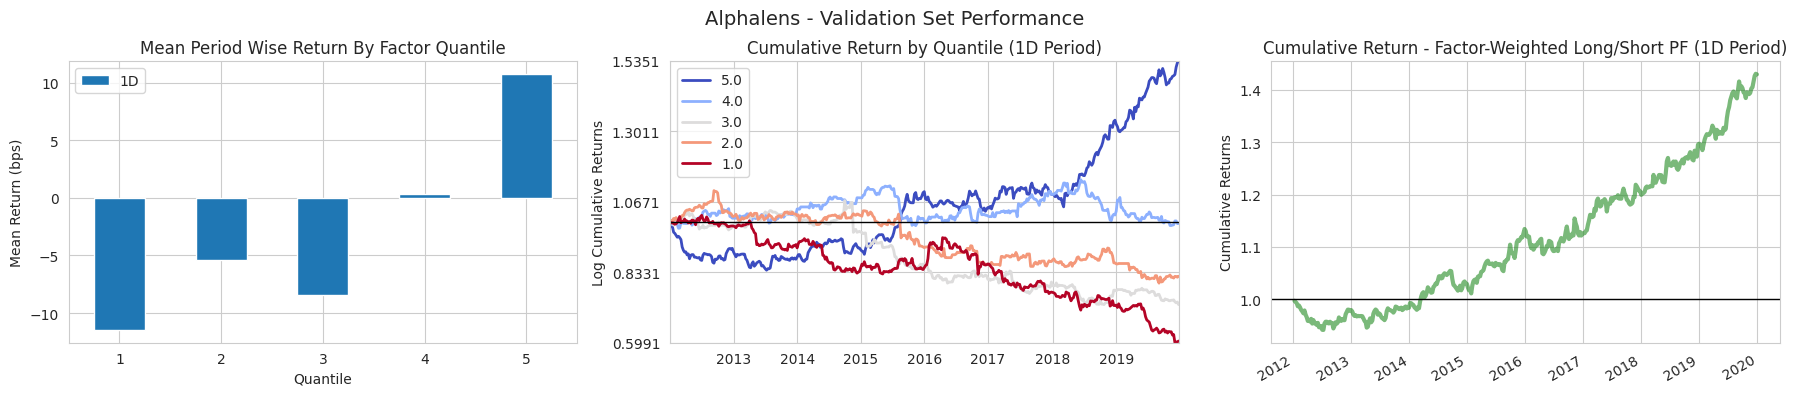

In [210]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.590461,0.581416,0.000957,0.208947,1038,22.629169
2.0,-0.510932,0.603112,0.045313,0.203294,858,18.705036
3.0,-0.470864,0.644397,0.076123,0.207485,903,19.686069
4.0,-0.449492,0.670963,0.096436,0.220309,781,17.026379
5.0,-0.401889,0.780980,0.145903,0.212565,1007,21.953346


Returns Analysis


,1D
Ann. alpha,0.223
beta,0.040
Mean Period Wise Return Top Quantile (bps),10.763
Mean Period Wise Return Bottom Quantile (bps),-11.465
Mean Period Wise Spread (bps),22.227


Information Analysis


,1D
IC Mean,0.049
IC Std.,0.356
Risk-Adjusted IC,0.138
t-stat(IC),2.819
p-value(IC),0.005
IC Skew,-0.017
IC Kurtosis,-0.557


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.745
Quantile 2 Mean Turnover,0.769
Quantile 3 Mean Turnover,0.775
Quantile 4 Mean Turnover,0.751
Quantile 5 Mean Turnover,0.719


,1D
Mean Factor Rank Autocorrelation,0.052


<Figure size 640x480 with 0 Axes>

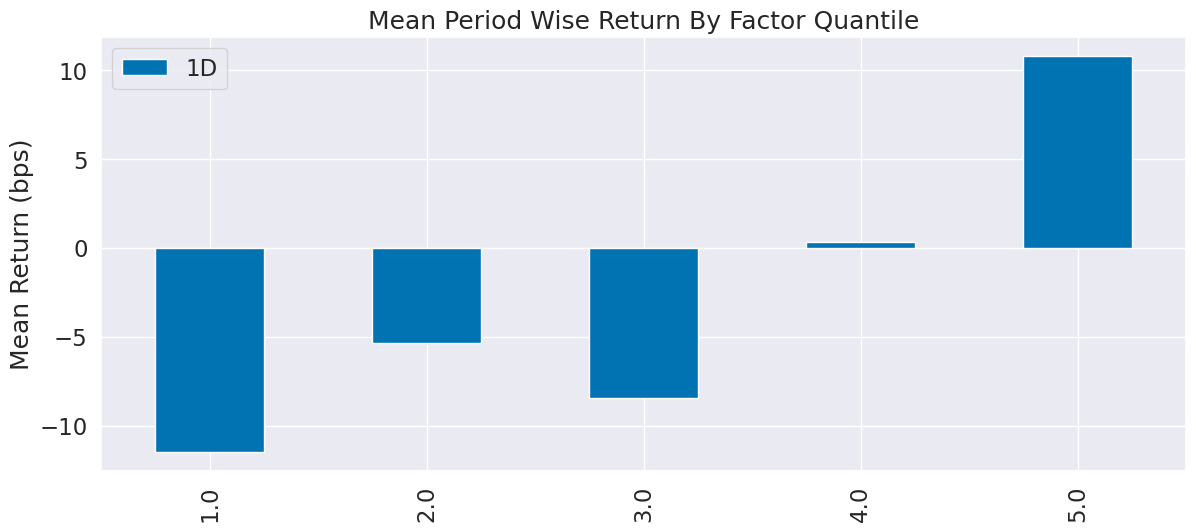

In [211]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.590461,0.581416,0.000957,0.208947,1038,22.629169
2.0,-0.510932,0.603112,0.045313,0.203294,858,18.705036
3.0,-0.470864,0.644397,0.076123,0.207485,903,19.686069
4.0,-0.449492,0.670963,0.096436,0.220309,781,17.026379
5.0,-0.401889,0.780980,0.145903,0.212565,1007,21.953346


Returns Analysis


,1D
Ann. alpha,0.223
beta,0.040
Mean Period Wise Return Top Quantile (bps),10.763
Mean Period Wise Return Bottom Quantile (bps),-11.465
Mean Period Wise Spread (bps),22.227


<Figure size 640x480 with 0 Axes>

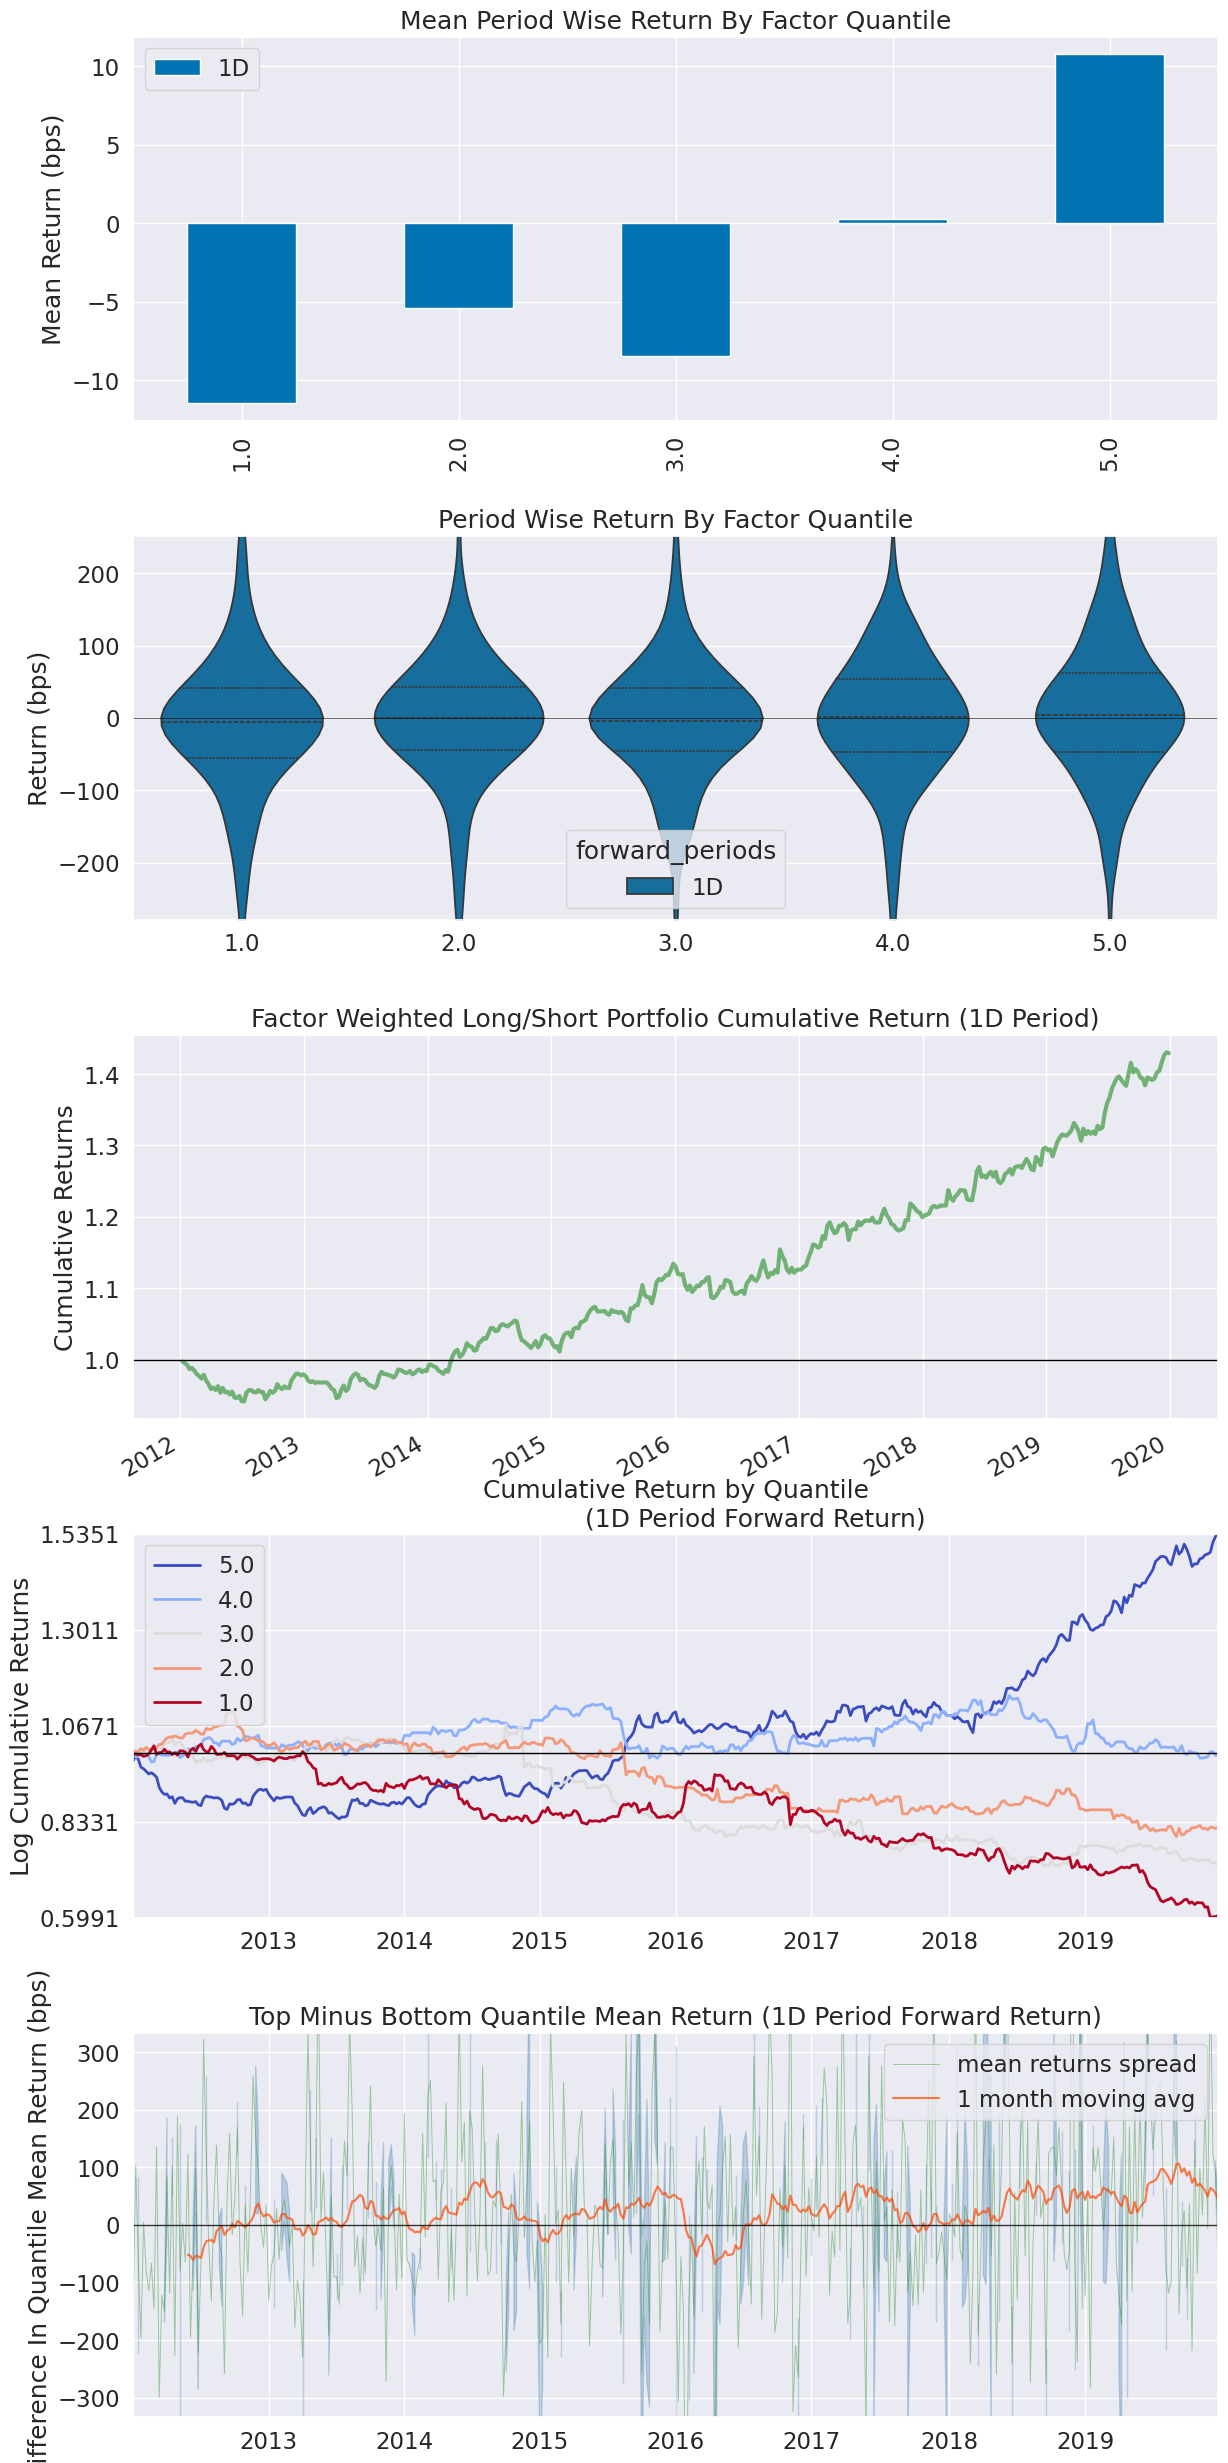

Information Analysis


,1D
IC Mean,0.049
IC Std.,0.356
Risk-Adjusted IC,0.138
t-stat(IC),2.819
p-value(IC),0.005
IC Skew,-0.017
IC Kurtosis,-0.557


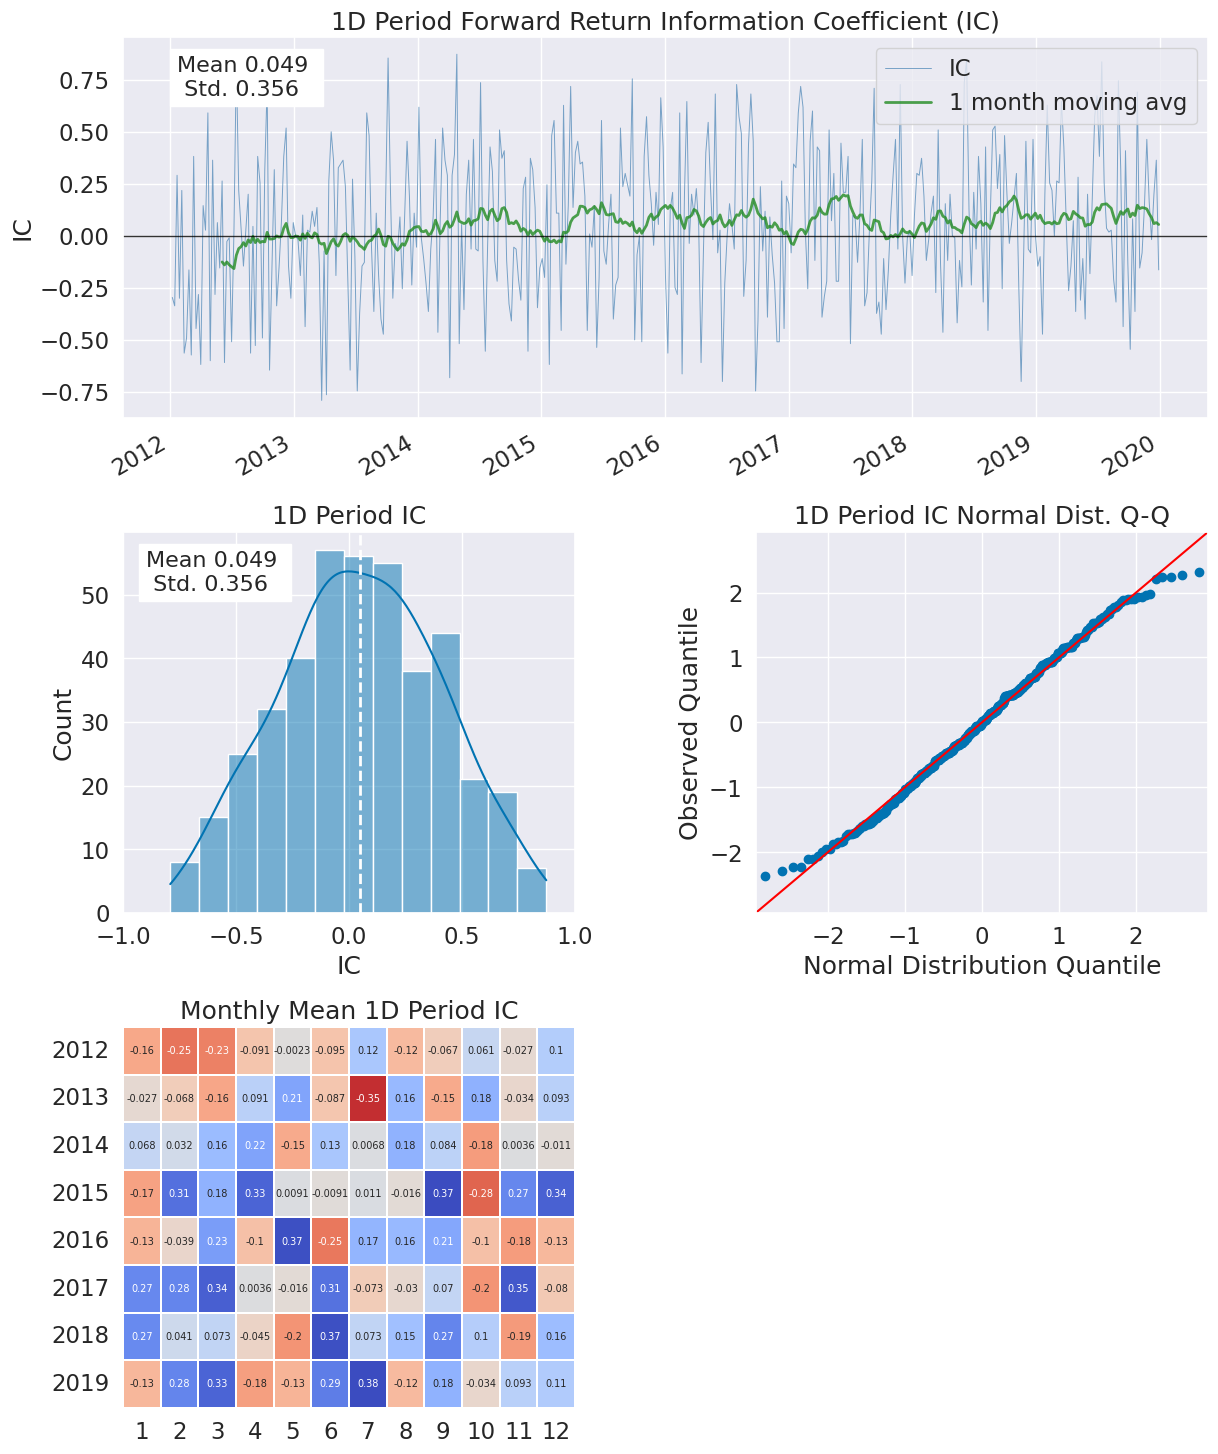

Turnover Analysis


,1D
Quantile 1.0 Mean Turnover,0.745
Quantile 2.0 Mean Turnover,0.769
Quantile 3.0 Mean Turnover,0.775
Quantile 4.0 Mean Turnover,0.751
Quantile 5.0 Mean Turnover,0.719


,1D
Mean Factor Rank Autocorrelation,0.052


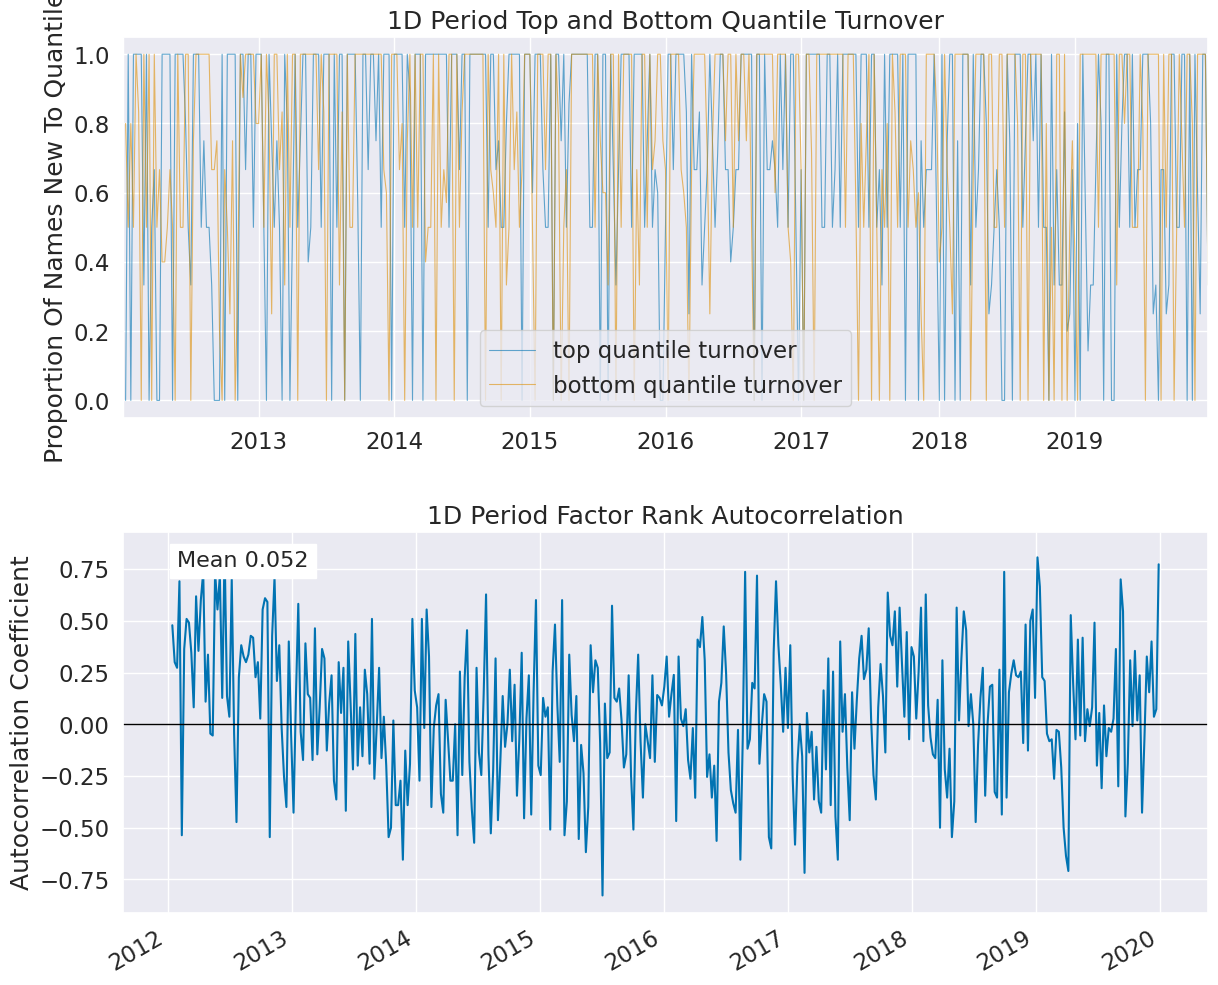

In [212]:
create_full_tear_sheet(factor_data)